# Monte Carlo Simulation

#### *Author : Hugo Michel*

Pricing options by Monte Carlo simulation is amongst the most popular ways to price certain types of financial options. In the case of closed formula doesn't exists such as American Option pricing, Monte Carlo simulation can be a good option to find the fair price of an option.

Monte Carlo methods, is a approch that rely on repeated random sampling to obtain numerical results. The underlying concept is to use randomness to solve problems that might be deterministic in principle. They are often used in physical and mathematical problems and are most useful when it is difficult or impossible to use other approaches. Monte Carlo methods are mainly used in three problem classes: optimization, numerical integration, and generating draws from a probability distribution

In this notebook we will focus on the European Call Option.

In order to simulate the price of a European call option, first we must decide on the process that the stock price follows throughout the life of the option $(T - t)$. In the financial litterature stocks are said to follow geometric brownian motion. 

To do so, we assume that the stock option $S$:

* doesn't pay any annual dividend $q$
* has an expected return $\mu$ equal to the risk-free rate $r-q$
* the volatility $\sigma$ is assumed to be constant
* The stock price can be modeled by a stochastic differential equation. The price movement can be describes as a GBM


Essentially this is a differential equation in which at least one of the terms is a random process. First it may be useful to consider an ordinary differential equation in the context of our problem. Let's consider the case when volatility is 0 i.e. the stock price can be described like a deposit in a savings account paying $\sigma$ per annum. The change in any given time increment is then given by:

$dS = \mu S dt$

Given the price of the stock no $S_0$ we then know with certainty the price $S_T$ at given time $T$ by separating and intergrating as follows:

$\int_{0}^{T} \frac{dS}{S} = \int_{0}^{T} \mu dt $ 

The solution of this equation gives:

$S_t = S_0 e^{\mu T}$

It may be useful to notice now that we can write the result above as $ln(S_t) = ln(S_0) + \int_{0}^{T} \mu dt $

However, since stock prices do exhibit randomness we need to include a stochastic term in the equation above. We can't simply integrate to get a nice result as we have in the equation above, in order to capture the randomness inherent in stock markets we add another term and are SDE is defined as follows:

$$
dS = S \mu dt + S \sigma dW(t)
$$

where $W_t$ is a Wiener process. This equation is nos in the form of an Ito process.

In order to proceed a short word on Ito's Lemma:
Ito's Lemma  shown below, states if a random variable follows an Ito Process (example above) then another twice differentiable function $G$ described by the stock price $S$ and time $t$ also follows at Ito process:

$dG(t, x) = \left( \frac{\partial G}{\partial S} S \mu + \frac{\partial G}{\partial t} + \frac{1}{2} \frac{\partial^2 G}{\partial S^2} S^2 \sigma^2 \right) dt + \frac{\partial G}{\partial S} S \sigma dW(t)$

We could apply the Ito's lemma to $G = S$ in order to obtain arithmetic Brownian motion, howver using $G = ln(S)$ which gives a nice property that the stock price is strictly greater than 0. So applying Ito's lemma to $ln(S)$ first we calculate the partia derivatives with respect to $t$ and $S$ as follows:

$G = ln(S)$

* $\frac{\partial G}{\partial S} = \frac{1}{S}$
* $\frac{\partial G}{\partial t} = 0$
* $\frac{\partial^2 G}{\partial S^2} = -\frac{1}{S^2}$

Plugging the partial derivatives into Ito's lemma gives:

$dG = (\frac{1}{S} S \mu + 0 - \frac{1}{2} \frac{1}{S^2} S^2 \sigma^2) dt + \frac{1}{S} S \sigma dW(t)$
$= (\mu - \frac{\sigma^2}{2}) dt + \sigma dW(t)$

Therefore the distribution of $ln(S_t) - ln(S_0) = (\mu - \frac{\sigma^2}{2})T + \sigma \sqrt{T}$

because, $var(dW(t)) = var(W(T) - W(0)) = n \cdot \Delta t = T  => std(W(T) - W(0)) = std(W(T)) = \sqrt{T} $

The distribution of the stock price at expiration is given by rearranging the equation above and taking the exponential of both sides:

$$
S_T = S_0 e^{(\mu - \frac{\sigma^2}{2})dt + \sigma dW(t)}
$$

Hence by taking the $log$ we have, 

$$
log(S_{T}) = log (S_0 e^{(\mu - \frac{\sigma^2}{2})T + \sigma dW(t)})
$$

$$
log(S_{T}) = log(S_{0})+(\mu-\frac{\sigma^2}{2})T+ \sigma dW(t)
$$

### Monte Carlo implementation

To implement the monte carlo in python, the goal to simulate (i.e generate randomly) multiple price trajectories that follows the Geometric Brownian Motion movement.

As we prove previously that the analytical solution of the SDE of the Geometric Brownnian Motion is as follow :

$$
log(S_{T}) = log(S_{0})+\int_{0}^T(\mu-\frac{\sigma^2}{2})dt+\int_{0}^T \sigma dW(t)
$$

We can now implement the Monte Carlo approach based on this equation.

We will follow the following the step to implmement the Monte Carlo approach:

1. Genererate $N$ paths price using analitycal solution of the Geometric Grownian Motion
2. Compute the average payoff: $ \text{avg_payoff} = \frac{1}{N} \sum_{i=1}^{N} (S_T - K)^+$
3. Discount the payoff: $\text{avg_payoff} * e^{-rt}$

### Step 1: Genereta paths price

Generate path price using the following formula:

In our case the drift $\mu$ is the risk free rate $r$

$$
log(S_{T}) = log(S_{0})+(\mu - \frac{\sigma^2}{2})T+ \sigma dW(t)
$$

Text(0.5, 1.0, 'Geometric Brownian Motion')

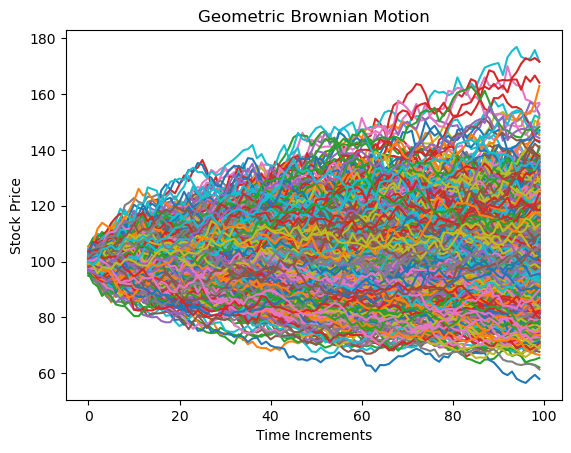

In [8]:
import numpy as np
import matplotlib.pyplot as plt


def geo_paths(S, T, r, q, sigma, steps, N):
    """
    Inputs
    #S = Current stock Price
    #K = Strike Price
    #T = Time to maturity 1 year = 1, 1 months = 1/12
    #r = risk free interest rate
    #q = dividend yield
    # sigma = volatility 
    
    Output
    # [steps,N] Matrix of asset paths 
    """
    dt = T/steps
    #S_{T} = ln(S_{0})+\int_{0}^T(\mu-\frac{\sigma^2}{2})dt+\int_{0}^T \sigma dW(t)
    ST_log = np.log(S) +  np.cumsum(((r - sigma**2/2)*dt +\
                              sigma*np.sqrt(dt) * \
                              np.random.normal(size=(steps,N))),axis=0)
    # Take the exponential to get the S_T
    ST = np.exp(ST_log)
    return ST

S = 100 #stock price S_{0}
K = 110 # strike
T = 1/2 # time to maturity
r = 0.05 # risk free risk in annual %
q = 0.02 # annual dividend rate
sigma = 0.25 # annual volatility in %
steps = 100 # time steps
N = 1000 # number of trials

paths= geo_paths(S,T,r, q,sigma,steps,N)

plt.plot(paths);
plt.xlabel("Time Increments")
plt.ylabel("Stock Price")
plt.title("Geometric Brownian Motion")

### Step 2 and Step 3 Compute the option of an European Call

Previously we generate $N$ price trajectories randomly.

The Monte Carlo algorithm prices option as $Call = e^{rT}[\frac{1}{N} \sum_{i=1}^{N} (S_T - K)^+]$ the $^+$ means that want the positive part of the call price.

To get the fair price of the option, we have to take compute the average price of the average payoff which for which the price $S_T$ at maturity is strictly greater than the strike $K$

To do so, in our case we have to to take the last price of each simulation and select all the price that are strictly greater than the strike price $K$: $(S_T - K)^+ = max(S_T - K, 0)$

The final step before to get the fair price of the call option is to discount the payoff using the risk free rate $r$ $max(S_T - K, 0)e^{-rT}$

In [9]:
payoffs = np.maximum(paths[-1]-K, 0)
option_price = np.mean(payoffs)*np.exp(-r*T) #discounting back to present value
option_price

3.8433471045212624

### Let's compare the price provided by the Closed formula of European Call of Black-Scholes and the price simulated by Monte Carlo approach

In [13]:
from scipy.stats import norm

def black_scholes_call(S,K,T,r,sigma):
    """
    Inputs
    #S = Current stock Price
    #K = Strike Price
    #T = Time to maturity 1 year = 1, 1 months = 1/12
    #r = risk free interest rate
    #q = dividend yield
    # sigma = volatility 
    
    Output
    # call_price = value of the option 
    """
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    return  S * norm.cdf(d1) - K * np.exp(-r*T)* norm.cdf(d2)

bs_price = black_scholes_call(S,K,T,r,sigma)

print(f"Black Scholes Price is {bs_price}")
print(f"Simulated price is {option_price}")

Black Scholes Price is 4.22578239296007
Simulated price is 3.8433471045212624


There is considerable difference between the two prices due to the low sample size chosen. Let's try changing N to 100000 and running the script again.

In [14]:
N=100000
paths= geo_paths(S, T, r, q,sigma, steps, N)

# compute the average price of the simulated paths
avg_price = np.mean(paths[-1])
print("avg_price", avg_price)

payoffs = np.maximum(paths[-1]-K, 0)
option_price = np.exp(-r*T)*np.mean(payoffs)

bs_price = black_scholes_call(S,K,T,r,sigma)

print(f"Black Scholes Price is {bs_price}")
print(f"Simulated price is {option_price}")

avg_price 102.56197558981586
Black Scholes Price is 4.22578239296007
Simulated price is 4.257052005827569


As we increase $N$ towards infinity the price approaches the Black-Scholes price, due to *Central Limit Theorem*.

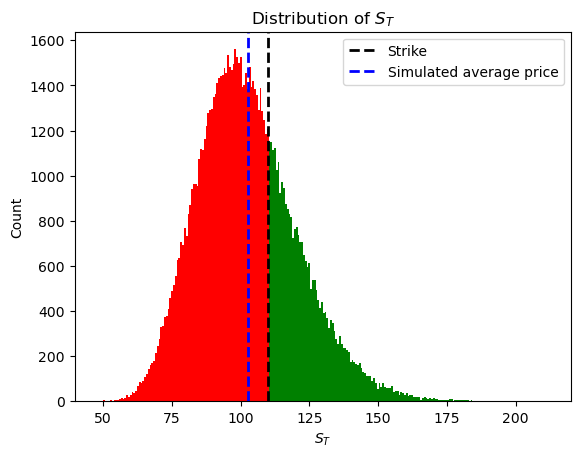

In [15]:
n, bins, patches = plt.hist(paths[-1],bins=250);
for c, p in zip(bins, patches):
    if c > K:
        plt.setp(p, 'facecolor', 'green')
    else:
        plt.setp(p, 'facecolor', 'red')

plt.axvline(K, color='black', linestyle='dashed', linewidth=2,label="Strike")
plt.axvline(avg_price, color='blue', linestyle='--', linewidth=2,label="Simulated average price")
plt.title("Distribution of $S_{T}$")
plt.xlabel("$S_{T}$")
plt.ylabel('Count')
plt.legend()

A visual representation of what is happening above

We can see that according to Central Limit Theorem, the average price $S_T$ at maturity is close to the mean of the normal distribution

### Monte Carlo with dividend

Now we will take into account of the annuel dividend $q$, so the drift become $\mu = r-q$

The GBM becomes: 

$$
log(S_{T}) = log(S_{0})+\int_{0}^T(\mu-\frac{\sigma^2}{2})dt+\int_{0}^T \sigma dW(t)
$$

$$
log(S_{T}) = log(S_{0})+\int_{0}^T(r - q-\frac{\sigma^2}{2})dt+\int_{0}^T \sigma dW(t)
$$

$$
log(S_{T}) = log(S_{0})+(r - q - \frac{\sigma^2}{2})T+ \sigma dW(t)
$$

Text(0.5, 1.0, 'Geometric Brownian Motion with annual dividend')

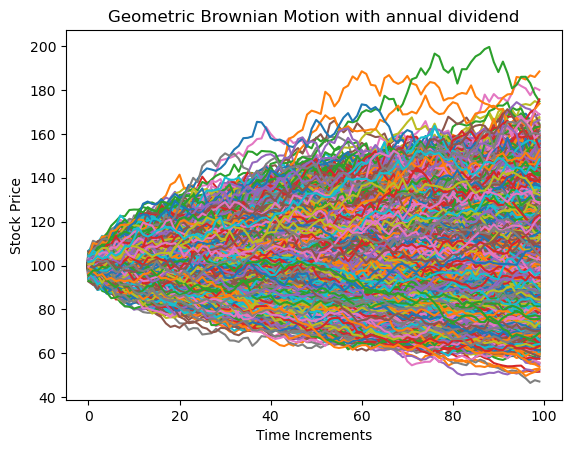

In [25]:
q = 0.02 # annual dividend rate

def geo_paths_dividend(S, T, r, q, sigma, steps, N):
    """
    Inputs
    #S = Current stock Price
    #K = Strike Price
    #T = Time to maturity 1 year = 1, 1 months = 1/12
    #r = risk free interest rate
    #q = dividend yield
    # sigma = volatility 
    
    Output
    # [steps,N] Matrix of asset paths 
    """
    dt = T/steps
    #S_{T} = ln(S_{0})+\int_{0}^T(\mu-\frac{\sigma^2}{2})dt+\int_{0}^T \sigma dW(t)
    ST = np.log(S) +  np.cumsum(((r - q - sigma**2/2)*dt +\
                              sigma*np.sqrt(dt) * \
                              np.random.normal(size=(steps,N))),axis=0)
    
    return np.exp(ST)

S = 100 #stock price S_{0}
K = 110 # strike
T = 1/2 # time to maturity
r = 0.05 # risk free risk in annual %
q = 0.02 # annual dividend rate
sigma = 0.25 # annual volatility in %
steps = 100 # time steps
N = 10000 # number of trials

paths_dividends = geo_paths_dividend(S,T,r, q,sigma,steps,N)

plt.plot(paths_dividends);
plt.xlabel("Time Increments")
plt.ylabel("Stock Price")
plt.title("Geometric Brownian Motion with annual dividend")

In [28]:
payoffs_dividend = np.maximum(paths_dividends[-1]-K, 0)
option_price_dividend = np.mean(payoffs_dividend)*np.exp(-r*T) #discounting back to present value
option_price_dividend

3.740116518819802

### Black-Scholes with dividend

**Call**

$Call = S_0 e^{-q(T)}\Phi(d_1) - Ke^{-r(T)} \Phi(d_2)$


**Put**

$Put = Ke^{-r(T)}\Phi(-d_2) - S_0 e^{-q(T)}\Phi(-d_1)$


with:

$d_1 = \frac{\ln\left(\frac{S_0}{K}\right) + \left(r - q + \frac{\sigma^2}{2}\right)(T)}{\sigma\sqrt{T}}$

$d_2 = d_1 - \sigma\sqrt{T-t}$

In [29]:
def black_scholes_call_dividend(S,K,T,r,q,sigma):
    """
    Inputs
    #S = Current stock Price
    #K = Strike Price
    #T = Time to maturity 1 year = 1, 1 months = 1/12
    #r = risk free interest rate
    #q = dividend yield
    # sigma = volatility 
    
    Output
    # call_price = value of the option 
    """
    d1 = (np.log(S/K) + (r - q + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    
    call = S * np.exp(-q*T)* norm.cdf(d1) - K * np.exp(-r*T)*norm.cdf(d2)
    return call

bs_price_dividend = black_scholes_call_dividend(S,K,T,r,q,sigma)

print(f"Black Scholes Price is {bs_price_dividend}")
print(f"Simulated price is {option_price_dividend}")

Black Scholes Price is 3.859759950774997
Simulated price is 3.740116518819802


### Case of Path Dependent Options

The main limitation of Monte Carlo is that this method is highly computational, not accurate as Black-Scholes approach. It may seem like the above was largely unnecessary since we have the Black-Scholes equation, since it takes longer and is less accurate. 

However, there are a number of cases where a closed form solution is not readily available. Consider again the plot of paths at the beginning of the document. Let's say for some reason someone wants to buy an option that allows the holder to exercise at the most favorable price throughout the specified time interval. Take for example, if the stock in question follows the path below, the holder of this option would be able to choose $S_{max}$ (dashed red line below). 

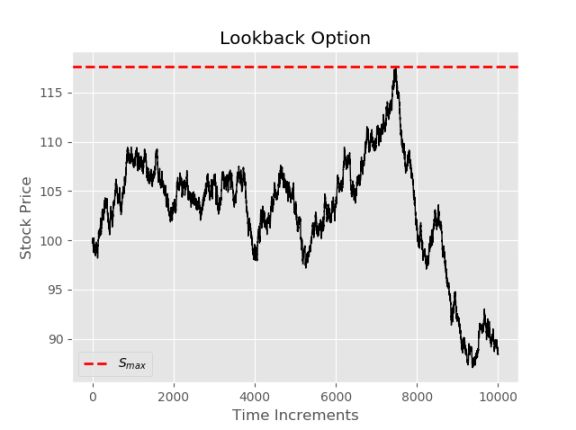

Let's plot now the distribution of the maximum price of each path.

A visual for comparison is as follow

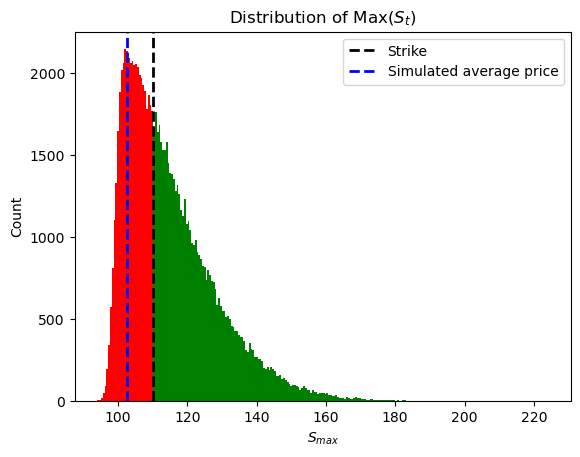

In [16]:
max_=np.max(paths,axis=0)
n, bins, patches = plt.hist(max_,bins=250);
for c, p in zip(bins, patches):
    if c > K:
        plt.setp(p, 'facecolor', 'green')
    else:
        plt.setp(p, 'facecolor', 'red')
plt.axvline(K, color='black', linestyle='dashed', linewidth=2,label="Strike")
plt.axvline(avg_price, color='blue', linestyle='--', linewidth=2,label="Simulated average price")
plt.title("Distribution of Max($S_{t}$)")
plt.xlabel("$S_{max}$")
plt.ylabel('Count')
plt.legend()

Similarly as previously, when we calculated the fair price of an European option price, the price calculated to the vanilla option:

$$
lookback = e^{rT}[\frac{1}{N} \sum_{i=1}^{N} (S_{max} - K)^+]
$$

In [17]:
max_=np.max(paths,axis=0)
payoffs = np.maximum(max_-K, 0)
lookback_price = np.mean(payoffs)*np.exp(-r*T)
print(f"lookback price is {lookback_price}")

lookback price is 7.538847941699931
